In [ ]:
!pip install earthengine-api

In [ ]:
!pip install geemap

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
!pip install scikit-image


In [ ]:
!pip install geopandas rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 44.1 MB/s eta 0:00:00


In [ ]:
!earthengine authenticate

Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0921 16:25:20.118282 133787434700800 _default.py:683] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=v1M1afNcbzkBFhgL9itSbYEMCCnmqPPI0SCHWDbw6jk&tc=qiwwWudQK-Ht12SR84v5fbeysVMA32hk-l4wHiqjON4&cc=tecXEvy3cjdtaGN7T87pj0j3rCg7iM5ltJNZ0WFJpYY

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AQlEd8xB-iuy2TO712OQrzCi0n9t

In [ ]:
!pip install fastkml


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.3 MB/s eta 0:00:00
  Created wheel for pygeoif: filename=pygeoif-0.7-py3-none-any.whl size=19001 sha256=7a3e30c78c364d7e337458d717b9966b35bcc1c56f6e98e87c816a6095bc052f
  Stored in directory: /root/.cache/pip/wheels/22/24/2c/811afb826232cb08e23a7a5e889bcf1edf3dd12ed37914b7d1
Successfully built pygeoif


In [ ]:
# prompt: how to authenticate to a gee project
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


# Import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import ee
import geopandas as gpd
import geemap
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
import xgboost as xgb
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
ee.Authenticate()


# 1. Exploratory Data Analysis

# 1.1 Visualizing ESA WorldCover Data for the Kabylie Region

In [ ]:
# Create a map for visualization
Map = geemap.Map()
# Define the Kabylie region as the area of interest (AOI)
kabylie = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load ESA WorldCover dataset
worldCover = ee.ImageCollection('ESA/WorldCover/v100').first()

# Visualization parameters for WorldCover
vis_params = {
    'bands': ['Map'],
    'min': 10,
    'max': 100,
    'palette': ['006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75']
}

# Add the WorldCover data to the map
Map.addLayer(worldCover.clip(kabylie), vis_params, 'WorldCover')

# Display the map
Map.centerObject(kabylie, 9)
Map.addLayerControl()
Map


Map(center=[36.80348934319949, 4.499999999999918], controls=(WidgetControl(options=['position', 'transparent_b…

## 1.2 Exporting and Visualizing Sentinel-2 Satellite Data for the AOI

In [ ]:
# Define the area of interest (AOI)
aoi = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load Sentinel-2 Harmonized Collection and filter by date and bounds
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2020-01-01', '2020-12-31').filterBounds(aoi)
satellite_image = sentinel.median()

# Export the satellite image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=satellite_image.clip(aoi),
    description='Sentinel2_Export',
    scale=10,
    region=aoi,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# Start the export task
task.start()


# Visualize the data using geemap
m = geemap.Map()
m.centerObject(aoi, zoom=10)
m.addLayer(satellite_image.clip(aoi), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')
m


Map(center=[36.80348934319949, 4.499999999999918], controls=(WidgetControl(options=['position', 'transparent_b…

## 1.3 Sampling and Exporting Validation Points for Forest Masking using Sentinel-2 and ESA WorldCover Data

In [ ]:
# Define the Kabylie region as the area of interest (AOI)
aoi = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load ESA WorldCover dataset as an image (first image in the collection)
worldCover = ee.ImageCollection('ESA/WorldCover/v100').first().select('Map').clip(aoi)

# Load Sentinel-2 Harmonized Collection, filter by date and region
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2020-01-01', '2020-12-31').filterBounds(aoi).median()

# Define the number of validation points
num_validation_points = 2000

# Sample validation points from both Sentinel-2 and WorldCover data
validation_points = sentinel.addBands(worldCover).sample(
    region=aoi,
    scale=10,
    numPixels=num_validation_points,
    seed=1,
    tileScale=4
)

# Export the validation points to Google Drive as a shapefile
task = ee.batch.Export.table.toDrive(**{
    'collection': validation_points,
    'description': 'ValidationDataset_Export',
    'fileFormat': 'SHP',
    'folder': 'EarthEngineExports'
})

task.start()
print('Validation points export task started.')

# Apply a mask to only show forest areas (WorldCover class 10 is forest)
forestMask = worldCover.eq(10)  # WorldCover class 10 represents forests
forestOnly = worldCover.updateMask(forestMask)

# Add the forest layer to the map
m = geemap.Map()
m.centerObject(aoi, zoom=10)
m.addLayer(forestOnly.clip(aoi), {'min': 10, 'max': 100, 'palette': ['006400']}, 'WorldCover Forests')
m.addLayer(sentinel.clip(aoi), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')
m


Validation points export task started.


Map(center=[36.80348934319949, 4.499999999999918], controls=(WidgetControl(options=['position', 'transparent_b…

### Loading and Inspecting Validation Polygons from Shapefile

In [ ]:
# Load the validation shapefile (digitized polygons)
validation_data = gpd.read_file('/content/drive/MyDrive/ValidationData_Export/ValidationData_Export.shp')

# Print validation data to inspect
print(validation_data.head())


                                            geometry
0  MULTIPOLYGON (((3.8409 36.71549, 3.88313 36.72...


## 1.4 Summary Statistics of Validation Data

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1 non-null      geometry
dtypes: geometry(1)
memory usage: 136.0 bytes
None
                                                 geometry
count                                                   1
unique                                                  1
top     MULTIPOLYGON (((3.840901947476709 36.715486512...
freq                                                    1
Coordinate Reference System (CRS): EPSG:4326


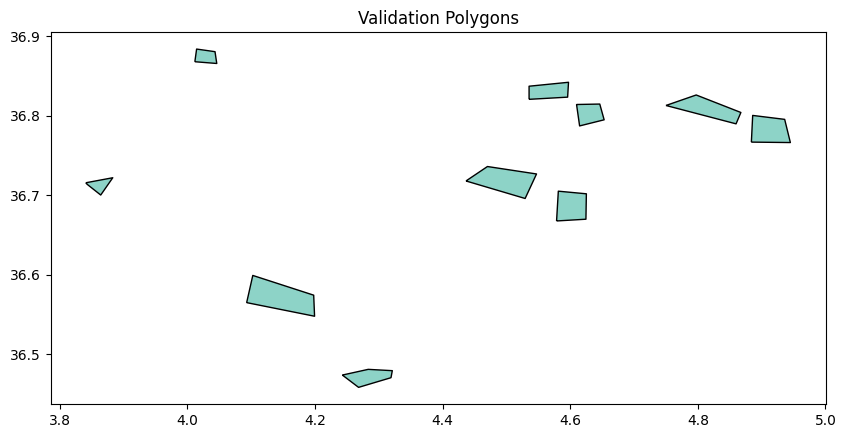

In [ ]:
# Load the validation shapefile
validation_data = gpd.read_file('/content/drive/MyDrive/ValidationData_Export/ValidationData_Export.shp')

# Display summary statistics and information
print(validation_data.info())  # Information about the data types, CRS, and number of features
print(validation_data.describe())  # Basic statistics (e.g., area, geometry)

# Check the coordinate reference system (CRS)
print("Coordinate Reference System (CRS):", validation_data.crs)

# Plot the validation polygons
validation_data.plot(figsize=(10, 8), edgecolor='black', cmap='Set3')
plt.title("Validation Polygons")
plt.show()


## 1.5 Check for missing or null geometries

In [ ]:
# Check for missing or null geometries in the validation dataset
missing_geometries = validation_data['geometry'].isnull().sum()

# Display the count of missing geometries
print(f"Number of missing geometries: {missing_geometries}")


Number of missing geometries: 0


# 2. Feature Extraction

## 2.1 NDVI Calculation and Visualization

In [ ]:
# Define the area of interest (AOI)
aoi = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load Sentinel-2 Harmonized Collection and filter by date and region
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2020-01-01', '2020-12-31') \
    .filterBounds(aoi) \
    .median()

# Calculate NDVI (Normalized Difference Vegetation Index)
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Export the NDVI layer to Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': ndvi.clip(aoi),
    'description': 'Sentinel2_NDVI_Export',
    'scale': 10,
    'region': aoi,
    'maxPixels': 1e13,
    'fileFormat': 'GeoTIFF'
})

# Start the export task
task.start()

# Visualization for NDVI
ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['blue', 'white', 'green']  # Better contrast between low and high NDVI
}

# Create the map for visualization
m = geemap.Map(center=[36.7, 4.0], zoom=10)

# Add NDVI layer to the map
m.addLayer(ndvi.clip(aoi), ndvi_vis, 'NDVI')

# Add a layer control to switch layers on/off
m.addLayerControl()

# Display the map by calling the map object directly
m


Map(center=[36.7, 4.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

# 3. Model Training

### 3.1 Loading and Aligning WorldCover Forest Mask and NDVI Data for Analysis

In [ ]:
# Load WorldCover forest data (binary mask, forest=1, non-forest=0)
forest_path = '/content/drive/MyDrive/ValidationData_Export/ValidationData_Export_rasterized.tif'
ndvi_path = '/content/drive/MyDrive/EarthEngineExports/Sentinel2_Export-0000004608-0000004608.tif'

with rasterio.open(forest_path) as forest_raster:
    forest_data = forest_raster.read(1)  # Load band data (forest mask)
    forest_transform = forest_raster.transform

with rasterio.open(ndvi_path) as ndvi_raster:
    ndvi_data = ndvi_raster.read(1)  # Load NDVI band data
    ndvi_transform = ndvi_raster.transform

# Check if the two rasters align and match CRS
assert forest_raster.crs == ndvi_raster.crs, "CRS mismatch between NDVI and WorldCover data"


### 3.2 Resampling NDVI Data to Match Forest Mask Resolution

In [ ]:
from rasterio.warp import reproject, Resampling

# Resample NDVI to match the forest data resolution (if needed)
if forest_raster.shape != ndvi_raster.shape:
    ndvi_resampled = np.zeros(forest_raster.shape, dtype=ndvi_data.dtype)
    reproject(
        source=ndvi_data,
        destination=ndvi_resampled,
        src_transform=ndvi_transform,
        dst_transform=forest_transform,
        src_crs=ndvi_raster.crs,
        dst_crs=forest_raster.crs,
        resampling=Resampling.nearest
    )
    ndvi_data = ndvi_resampled


### 3.3 Preparing and Flattening Feature Arrays for Forest Classification

In [ ]:
# Stack the features (e.g., NDVI and potentially other bands)
features = np.stack([ndvi_data], axis=-1)  # Add other bands like NIR, Red if available

# Flatten the arrays for classification
X = features.reshape(-1, features.shape[-1])  # Features (e.g., NDVI)
y = forest_data.reshape(-1)  # Labels (forest = 1, non-forest = 0)

# Remove missing or invalid data (e.g., -9999 for no data)
valid_mask = (y >= 0) & (X[:, 0] != -9999)  # Adjust conditions as needed
X = X[valid_mask]
y = y[valid_mask]


In [ ]:
X

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

### 3.4 Imputation, Train-Test Split, and Sampling for Forest Classification Dataset

In [ ]:
# Create an imputer to fill NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Apply imputer to features (X)
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Sample 1 million records from X_train and y_train
np.random.seed(42)  # For reproducibility
if X_train.shape[0] > 1000000:  # Ensure we have enough records
    sample_indices = np.random.choice(X_train.shape[0], size=1000000, replace=False)
    X_train_sampled = X_train[sample_indices]
    y_train_sampled = y_train[sample_indices]
if X_test.shape[0] > 1000000:  # Ensure we have enough records
    sample_indices = np.random.choice(X_test.shape[0], size=1000000, replace=False)
    X_test_sampled = X_test[sample_indices]
    y_test_sampled = y_test[sample_indices]
else:
    X_train_sampled, y_train_sampled = X_train, y_train  # Use all if less than 1 million

# Check shapes of the sampled datasets
print(f"Sampled X_train shape: {X_train_sampled.shape}")
print(f"Sampled y_train shape: {y_train_sampled.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Sampled X_train shape: {X_test_sampled.shape}")
print(f"Sampled y_train shape: {y_test_sampled.shape}")



Sampled X_train shape: (1000000, 1)
Sampled y_train shape: (1000000,)
X_test shape: (9388416, 1)
Sampled X_train shape: (1000000, 1)
Sampled y_train shape: (1000000,)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(37553664, 1)
(37553664,)
(9388416, 1)
(9388416,)


### 3.5 Training and Evaluating a RandomForest Classifier for Forest Classification

In [ ]:
# Train the RandomForest model
rf = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42)  # Use square root of features
rf.fit(X_train_sampled, y_train_sampled)

# Evaluate the model
y_pred = rf.predict(X_test_sampled)
print(f"Initial Accuracy: {accuracy_score(y_test_sampled, y_pred):.4f}")

Initial Accuracy: 0.9680


In [ ]:
import joblib
# Save the model to a file
model_filename = "/content/drive/MyDrive/ValidationData_Export/random_forest_model.pkl"
joblib.dump(rf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /content/drive/MyDrive/ValidationData_Export/random_forest_model.pkl


### 3.6 Pseudo-Labeling with RandomForest Classifier for Semi-Supervised Learning

In [ ]:
# Predict probabilities on the unlabeled data
y_proba = rf.predict_proba(X_test_sampled)

# Pseudo-labeling: Add confident predictions as new training data
confidence_threshold = 0.9  # Only consider predictions with >90% confidence
pseudo_labels = np.argmax(y_proba, axis=1)  # Get predicted labels
confident_predictions = np.max(y_proba, axis=1) > confidence_threshold

# Add confident pseudo-labels to the training set
X_train_pseudo = np.vstack([X_train_sampled, X_test_sampled[confident_predictions]])
y_train_pseudo = np.concatenate([y_train_sampled, pseudo_labels[confident_predictions]])

# Retrain the model with the original and pseudo-labeled data
rf.fit(X_train_pseudo, y_train_pseudo)

# Evaluate again
y_pred = rf.predict(X_test_sampled)
print(f"Accuracy After Pseudo-Labeling: {accuracy_score(y_test_sampled, y_pred):.4f}")


Accuracy After Pseudo-Labeling: 0.9680


SUMMARY


Resampling NDVI: We ensured that the NDVI data matched the forest raster data resolution before proceeding with the feature extraction.

Stacking Features: NDVI was used as a feature, and other bands could potentially be added for classification purposes.

Handling Missing Data: We used SimpleImputer to handle NaN values in the features, replacing them with the mean.

RandomForest Training: The model was trained using a random forest classifier after selecting a subset of 1 million records for both training and testing.

Pseudo-Labeling (Active Learning): This is where we applied an active learning technique. We used the trained RandomForest model to predict on the test set, identified confident predictions (with a confidence threshold of 0.9), and added these confidently predicted labels as new pseudo-labels. Then, they retrained the model with the combined original and pseudo-labeled data.

### 3.7 Training and Evaluating XGBoost Classifier for Forest Classification

In [ ]:
# Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)
xgb_clf.fit(X_train_sampled, y_train_sampled)

# Predict and evaluate the performance
xgb_preds = xgb_clf.predict(X_test_sampled)
xgb_accuracy = accuracy_score(y_test_sampled, xgb_preds)
print(f"XGBoost Classifier Accuracy: {xgb_accuracy * 100:.2f}%")

XGBoost Classifier Accuracy: 96.84%


In [ ]:
# Save the XGBoost model to a file
xgb_model_filename = "/content/drive/MyDrive/ValidationData_Export/xgboost_model.pkl"
joblib.dump(xgb_clf, xgb_model_filename)

print(f"XGBoost model saved to {xgb_model_filename}")

XGBoost model saved to /content/drive/MyDrive/ValidationData_Export/xgboost_model.pkl


# 4 .Validation

### 4.1 Parsing and Inspecting Geometries from a KML File Using fastkml

In [ ]:
from fastkml import kml

# Load the KML file and remove the XML declaration
with open('/content/drive/MyDrive/ValidationData_Export/algiers.kml', 'r') as f:
    kml_content = f.read()

# Remove the first line (XML declaration)
kml_content = '\n'.join(kml_content.split('\n')[1:])

# Parse the KML
k = kml.KML()
k.from_string(kml_content)

# Extract the features
features = list(k.features())

# Assuming there's only one feature (Placemark)
placemark = list(features[0].features())[0]

# Print the geometry type for debugging
geometry = placemark.geometry

# Print the type of geometry to understand what we're dealing with
print(f"Geometry type: {type(geometry)}")

# If it's a GeometryCollection or MultiGeometry, print each sub-geometry type
if hasattr(geometry, 'geoms'):
    for i, geom in enumerate(geometry.geoms):
        print(f"Sub-geometry {i} type: {type(geom)}")
else:
    print("No sub-geometries found.")


Geometry type: <class 'pygeoif.geometry.MultiPolygon'>
Sub-geometry 0 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 1 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 2 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 3 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 4 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 5 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 6 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 7 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 8 type: <class 'pygeoif.geometry.Polygon'>
Sub-geometry 9 type: <class 'pygeoif.geometry.Polygon'>


### 4.2 Extracting Polygons from KML and Applying AOI in Earth Engine for Sentinel-2 Image Collection

In [ ]:
import ee
from fastkml import kml
import pygeoif

# Initialize Earth Engine
ee.Initialize()

# Load the KML file
kml_file_path = '/content/drive/MyDrive/ValidationData_Export/algiers.kml'
with open(kml_file_path, 'r') as file:
    kml_content = file.read()

# Remove the XML declaration line from KML file (if it exists)
kml_content = '\n'.join(kml_content.split('\n')[1:])

# Parse KML content
k = kml.KML()
k.from_string(kml_content)

# Extract features from KML
features = list(k.features())
placemark = list(features[0].features())[0]  # Assuming the KML has only one placemark

# Get the geometry of the placemark
geometry = placemark.geometry

# Check if geometry is a MultiPolygon or Polygon
if isinstance(geometry, pygeoif.geometry.MultiPolygon):
    # If MultiPolygon, extract the first polygon's exterior coordinates
    coords = list(geometry.geoms[0].exterior.coords)
elif isinstance(geometry, pygeoif.geometry.Polygon):
    # If Polygon, directly extract the exterior coordinates
    coords = list(geometry.exterior.coords)
else:
    raise ValueError("The KML does not contain valid polygons or multipolygons.")

# Ensure the coordinates are in the correct format for Earth Engine (longitude, latitude)
ee_coords = [[list([coord[0], coord[1]]) for coord in coords]]  # Remove the Z coordinate if present
# Ensure the first and last coordinates match (closing the polygon)
if ee_coords[0][0] != ee_coords[0][-1]:
    ee_coords[0].append(ee_coords[0][0])  # Close the polygon

# Create an Earth Engine Polygon
aoi = ee.Geometry.Polygon(ee_coords)

# Print AOI to verify
print(aoi.getInfo())

# Example: Apply this AOI to a Sentinel-2 image collection
sentinel = ee.ImageCollection('COPERNICUS/S2').filterBounds(aoi).filterDate('2020-01-01', '2020-12-31').median()

# Visualize the area on a map
Map = geemap.Map()
Map.centerObject(aoi, zoom=10)
Map.addLayer(sentinel.clip(aoi), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')
Map.addLayer(aoi, {}, 'AOI')
Map


{'type': 'Polygon', 'coordinates': [[[2.925557053098946, 36.75297953544558], [2.925501875213166, 36.75297312330952], [2.925446692872369, 36.75296671023561], [2.925355478671077, 36.75293112774448], [2.925278126331123, 36.75289721679992], [2.925214514756276, 36.75286523410103], [2.925148204558863, 36.75284548071195], [2.925070726606969, 36.75281238574922], [2.924965644558026, 36.75277638797285], [2.924877126760295, 36.75273007957892], [2.924799780279015, 36.75269722399987], [2.924719796694599, 36.75267614078167], [2.924656703524811, 36.75264420224662], [2.924563311526156, 36.75262107858875], [2.924511158390226, 36.75260280965539], [2.924461499628823, 36.75257333229844], [2.924370610867746, 36.75253918088396], [2.924304644644162, 36.75251963297671], [2.92425247846001, 36.75250161410244], [2.924162013330243, 36.75246708853334], [2.924085403376901, 36.75243408642527], [2.924033367328751, 36.75241605606661], [2.923973408727767, 36.75237310630666], [2.923924442999974, 36.75234331598519], [2.9

Map(center=[36.75149924302347, 2.9250875737620174], controls=(WidgetControl(options=['position', 'transparent_…

### 4.3 Calculating and Visualizing NDVI and NDWI from Sentinel-2 Data Using Earth Engine

In [ ]:
# Extract NDVI (Normalized Difference Vegetation Index)
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Extract NDWI (Normalized Difference Water Index)
ndwi = sentinel.normalizedDifference(['B3', 'B8']).rename('NDWI')

# Combine NDVI, NDWI, and other bands to create a feature stack
feature_stack = sentinel.addBands([ndvi, ndwi])

# Clip the feature stack to the AOI
clipped_features = feature_stack.clip(aoi)

# Define visualization parameters for NDVI and NDWI
ndvi_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
ndwi_params = {'min': -1, 'max': 1, 'palette': ['brown', 'white', 'blue']}

# Add the layers to the map
m.addLayer(clipped_features.select('NDVI'), ndvi_params, 'NDVI')
m.addLayer(clipped_features.select('NDWI'), ndwi_params, 'NDWI')

m


Map(bottom=204853.0, center=[36.73393165140215, 2.9827880859375], controls=(WidgetControl(options=['position',…

### 4.4 Convert the Algiers.kml File to a Usable Format


In [ ]:
import ee
from fastkml import kml
import pygeoif
import geopandas as gpd

# Initialize Earth Engine
ee.Initialize()

# Load the KML file
kml_file_path = '/content/drive/MyDrive/ValidationData_Export/algiers.kml'
with open(kml_file_path, 'r') as file:
    kml_content = file.read()

# Remove the XML declaration line from KML file (if it exists)
kml_content = '\n'.join(kml_content.split('\n')[1:])

# Parse KML content
k = kml.KML()
k.from_string(kml_content)

# Extract features from KML
features = list(k.features())
placemark = list(features[0].features())[0]  # Assuming the KML has only one placemark

# Get the geometry of the placemark
geometry = placemark.geometry

# Check if geometry is a MultiPolygon or Polygon
if isinstance(geometry, pygeoif.geometry.MultiPolygon):
    coords = list(geometry.geoms[0].exterior.coords)
elif isinstance(geometry, pygeoif.geometry.Polygon):
    coords = list(geometry.exterior.coords)
else:
    raise ValueError("The KML does not contain valid polygons or multipolygons.")

# Ensure coordinates are formatted correctly for Earth Engine
ee_coords = [[list([coord[0], coord[1]]) for coord in coords]]  # Remove the Z coordinate if present
if ee_coords[0][0] != ee_coords[0][-1]:
    ee_coords[0].append(ee_coords[0][0])  # Close the polygon

# Create Earth Engine Polygon
aoi = ee.Geometry.Polygon(ee_coords)


###  4.6 Load Sentinel-2 Data for the New Region

In [ ]:
# Load Sentinel-2 data for the AOI and date range
sentinel = ee.ImageCollection('COPERNICUS/S2')\
    .filterBounds(aoi)\
    .filterDate('2020-01-01', '2020-12-31')\
    .median()

# Extract NDVI and NDWI from the Sentinel-2 data
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = sentinel.normalizedDifference(['B3', 'B8']).rename('NDWI')

# Stack the features (NDVI and NDWI) with other bands
feature_stack = sentinel.addBands([ndvi, ndwi])

# Clip the features to the AOI (Algiers)
clipped_features = feature_stack.clip(aoi)

# Define visualization parameters
ndvi_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
ndwi_params = {'min': -1, 'max': 1, 'palette': ['brown', 'white', 'blue']}


### 4.7 Prepare the Data for Prediction

In [ ]:
# Extract NDVI (Normalized Difference Vegetation Index)
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Extract NDWI (Normalized Difference Water Index)
ndwi = sentinel.normalizedDifference(['B3', 'B8']).rename('NDWI')

# Combine NDVI, NDWI, and other bands to create a feature stack
feature_stack = sentinel.addBands([ndvi, ndwi])

# Clip the feature stack to the AOI
clipped_features = feature_stack.clip(aoi)

# Define visualization parameters for NDVI and NDWI (optional for visualizing)
ndvi_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
ndwi_params = {'min': -1, 'max': 1, 'palette': ['brown', 'white', 'blue']}


In [ ]:
try:
    # Sample within the bounds of the image instead of clipping, set a default value
    features_array = clipped_features.sampleRectangle(region=aoi, defaultValue=0).getInfo()

    # Check if 'NDVI' and 'NDWI' are in the properties of the sampled data
    if 'properties' in features_array:
        # Extract NDVI and NDWI arrays
        if 'NDVI' in features_array['properties'] and 'NDWI' in features_array['properties']:
            ndvi_array = features_array['properties']['NDVI']
            ndwi_array = features_array['properties']['NDWI']

            # Stack NDVI and NDWI as feature vectors
            import numpy as np
            X_new_region = np.dstack([ndvi_array, ndwi_array]).reshape(-1, 2)  # Use NDVI, NDWI
            print("Feature extraction successful.")
        else:
            print("NDVI or NDWI bands are missing in the sampled region.")
    else:
        print("No valid data extracted. The region may be outside the image bounds or fully masked.")

except Exception as e:
    print(f"Error during feature extraction: {e}")


Feature extraction successful.


### Load the Trained Model

In [ ]:
import joblib

# Load the trained Random Forest model
rf_model_filename = '/content/drive/MyDrive/ValidationData_Export/random_forest_model.pkl'
rf_clf = joblib.load(rf_model_filename)

# Load the trained XGBoost model
xgb_model_filename = '/content/drive/MyDrive/ValidationData_Export/xgboost_model.pkl'
xgb_clf = joblib.load(xgb_model_filename)


### Predict Forest Presence in the New Region

In [ ]:
# Predict forest vs non-forest using Random Forest with only NDVI
X_new_region_ndvi = ndvi_array.reshape(-1, 1)  # Only use NDVI as a feature
rf_preds_new_region = rf_clf.predict(X_new_region_ndvi)
